In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from scipy.sparse.linalg import eigsh
import sys


sys.path.append('../')
from src.utils import *

np.set_printoptions(legacy='1.25')

In [10]:
df = pd.read_csv('../Data/fb.edges')
g = nx.from_pandas_edgelist(df, source = 'i', target = 'j', edge_attr = 'w')

In [30]:
fv = np.logspace(-3, -1, 25)
nodes = np.arange(n)
n_iter = 10
S = np.zeros((len(fv), n_iter))
for i, f in enumerate(fv):
    print(f'f: {np.round(f, 2)}', end = '\r')

    for j in range(n_iter):
        idx = np.random.binomial(1, f, n) == 1

        # Erdos-Renyi
        g_ = nx.subgraph(g, nodes[idx])
        S[i,j] = len(max([x for x in nx.connected_components(g_)], key = len))/n

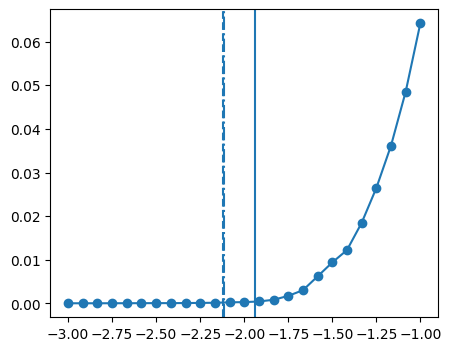

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (5,4))

ax.plot(np.log10(fv), np.mean(S, axis = 1), label = 'ER', marker = 'o')
d = np.array([x[1] for x in g.degree()])

MolloyReed = (np.mean(d**2)/np.mean(d)-1)**(-1)
ax.axvline(np.log10(MolloyReed))

A = nx.adjacency_matrix(g)
ρA = SpectralRadius(A)
ax.axvline(np.log10(1/ρA), linestyle = '--')

ρB = SpectralRadiusNB(A)
ax.axvline(np.log10(1/ρB), linestyle = '-.')


plt.show();


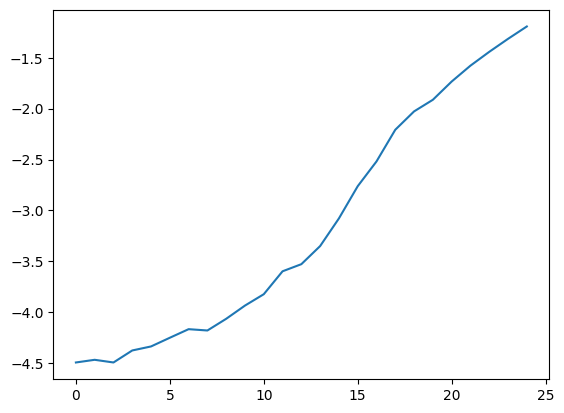

In [37]:
plt.plot(np.log10(np.mean(S, axis = 1)))